In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline

import seaborn as sns
sns.set()

# Input data files are available in the "../input/" directory.
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
# for dirname, _, filenames in os.walk('/kaggle/input'):
#     for filename in filenames:
#         print(os.path.join(dirname, filename))

In [2]:
df = pd.read_csv('/content/drive/MyDrive/5002/train_2.csv')
df.head()

,Page,2015-07-01,2015-07-02,2015-07-03,2015-07-04,2015-07-05,2015-07-06,2015-07-07,2015-07-08,2015-07-09,2015-07-10,2015-07-11,2015-07-12,2015-07-13,2015-07-14,2015-07-15,2015-07-16,2015-07-17,2015-07-18,2015-07-19,2015-07-20,2015-07-21,2015-07-22,2015-07-23,2015-07-24,2015-07-25,2015-07-26,2015-07-27,2015-07-28,2015-07-29,2015-07-30,2015-07-31,2015-08-01,2015-08-02,2015-08-03,2015-08-04,2015-08-05,2015-08-06,2015-08-07,2015-08-08,...,2017-08-02,2017-08-03,2017-08-04,2017-08-05,2017-08-06,2017-08-07,2017-08-08,2017-08-09,2017-08-10,2017-08-11,2017-08-12,2017-08-13,2017-08-14,2017-08-15,2017-08-16,2017-08-17,2017-08-18,2017-08-19,2017-08-20,2017-08-21,2017-08-22,2017-08-23,2017-08-24,2017-08-25,2017-08-26,2017-08-27,2017-08-28,2017-08-29,2017-08-30,2017-08-31,2017-09-01,2017-09-02,2017-09-03,2017-09-04,2017-09-05,2017-09-06,2017-09-07,2017-09-08,2017-09-09,2017-09-10
0,2NE1_zh.wikipedia.org_all-access_spider,18.0,11.0,5.0,13.0,14.0,9.0,9.0,22.0,26.0,24.0,19.0,10.0,14.0,15.0,8.0,16.0,8.0,8.0,16.0,7.0,11.0,10.0,20.0,18.0,15.0,14.0,49.0,10.0,16.0,18.0,8.0,5.0,9.0,7.0,13.0,9.0,7.0,4.0,11.0,...,46.0,24.0,22.0,22.0,11.0,25.0,45.0,39.0,17.0,18.0,13.0,57.0,18.0,14.0,19.0,39.0,22.0,16.0,28.0,21.0,37.0,58.0,25.0,23.0,25.0,47.0,44.0,26.0,24.0,21.0,19.0,33.0,33.0,18.0,16.0,27.0,29.0,23.0,54.0,38.0
1,2PM_zh.wikipedia.org_all-access_spider,11.0,14.0,15.0,18.0,11.0,13.0,22.0,11.0,10.0,4.0,41.0,65.0,57.0,38.0,20.0,62.0,44.0,15.0,10.0,47.0,24.0,17.0,22.0,9.0,39.0,13.0,11.0,12.0,21.0,19.0,9.0,15.0,33.0,8.0,8.0,7.0,13.0,2.0,23.0,...,39.0,20.0,31.0,19.0,7.0,11.0,20.0,13.0,16.0,16.0,47.0,21.0,20.0,12.0,13.0,20.0,22.0,20.0,12.0,37.0,14.0,34.0,16.0,31.0,34.0,33.0,32.0,29.0,34.0,25.0,32.0,30.0,11.0,19.0,54.0,25.0,26.0,23.0,13.0,81.0
2,3C_zh.wikipedia.org_all-access_spider,1.0,0.0,1.0,1.0,0.0,4.0,0.0,3.0,4.0,4.0,1.0,1.0,1.0,6.0,8.0,6.0,4.0,5.0,1.0,2.0,3.0,8.0,8.0,6.0,6.0,2.0,2.0,3.0,2.0,4.0,3.0,3.0,5.0,3.0,5.0,4.0,2.0,5.0,1.0,...,22.0,8.0,4.0,3.0,1.0,3.0,7.0,3.0,1.0,9.0,4.0,2.0,6.0,3.0,3.0,3.0,8.0,2.0,4.0,3.0,6.0,23.0,11.0,8.0,6.0,13.0,12.0,8.0,12.0,9.0,6.0,6.0,7.0,2.0,4.0,7.0,3.0,4.0,7.0,6.0
3,4minute_zh.wikipedia.org_all-access_spider,35.0,13.0,10.0,94.0,4.0,26.0,14.0,9.0,11.0,16.0,16.0,11.0,23.0,145.0,14.0,17.0,85.0,4.0,30.0,22.0,9.0,10.0,11.0,7.0,7.0,11.0,9.0,11.0,44.0,8.0,14.0,19.0,10.0,17.0,17.0,10.0,7.0,10.0,1.0,...,37.0,14.0,12.0,13.0,11.0,10.0,14.0,15.0,15.0,11.0,19.0,9.0,19.0,8.0,17.0,11.0,18.0,20.0,11.0,11.0,21.0,42.0,23.0,17.0,11.0,21.0,20.0,20.0,110.0,15.0,7.0,19.0,19.0,9.0,6.0,16.0,19.0,30.0,38.0,4.0
4,52_Hz_I_Love_You_zh.wikipedia.org_all-access_s...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,40.0,39.0,66.0,114.0,19.0,29.0,12.0,11.0,14.0,14.0,63.0,12.0,22.0,14.0,20.0,11.0,23.0,66.0,19.0,23.0,23.0,41.0,25.0,22.0,20.0,24.0,29.0,20.0,17.0,24.0,16.0,16.0,19.0,9.0,20.0,23.0,28.0,14.0,8.0,7.0


In [3]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 145063 entries, 0 to 145062
Columns: 804 entries, Page to 2017-09-10
dtypes: float64(803), object(1)
memory usage: 889.8+ MB


In [4]:
start_date = df.columns[1]
last_date = df.columns[-1]
print(f"Date range: {start_date} to {last_date}")

Date range: 2015-07-01 to 2017-09-10


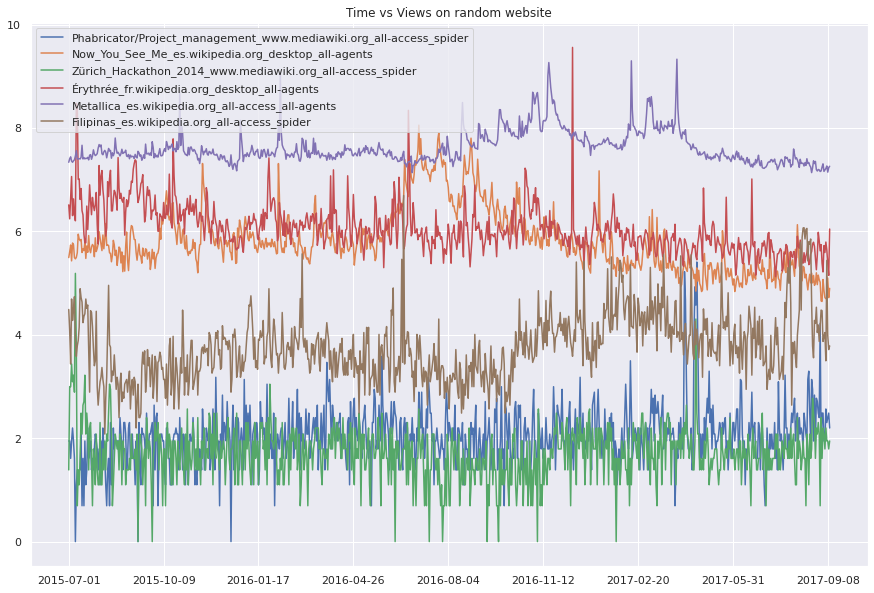

In [5]:
def plot_graph(df,n_series):
    sample = df.sample(n_series,random_state=42)
    page = sample["Page"].to_list()
    series_sample = sample.loc[:,start_date:last_date]
    plt.figure(figsize=(15,10))
    
    
    for i in range(series_sample.shape[0]):
        np.log1p(pd.Series(series_sample.iloc[i]).astype(np.float64)).plot(linewidth=1.5)
    
    plt.title("Time vs Views on random website")
    plt.legend(page)
plot_graph(df,6) 

In [6]:
from datetime import timedelta

pred_steps = 241
pred_length=timedelta(pred_steps)

first_day = pd.to_datetime(start_date) 
last_day = pd.to_datetime(last_date)

val_pred_start = last_day - pred_length + timedelta(1)
val_pred_end = last_day

train_pred_start = val_pred_start - pred_length
train_pred_end = val_pred_start - timedelta(days=1)
enc_length = train_pred_start - first_day

train_enc_start = first_day
train_enc_end = train_enc_start + enc_length - timedelta(1)

val_enc_start = train_enc_start + pred_length
val_enc_end = val_enc_start + enc_length - timedelta(1)
print('Train encoding:', train_enc_start, '-', train_enc_end)
print('Train prediction:', train_pred_start, '-', train_pred_end, '\n')
print('Val encoding:', val_enc_start, '-', val_enc_end)
print('Val prediction:', val_pred_start, '-', val_pred_end)

print('\nEncoding interval:', enc_length.days)
print('Prediction interval:', pred_length.days)

Train encoding: 2015-07-01 00:00:00 - 2016-05-16 00:00:00
Train prediction: 2016-05-17 00:00:00 - 2017-01-12 00:00:00 

Val encoding: 2016-02-27 00:00:00 - 2017-01-12 00:00:00
Val prediction: 2017-01-13 00:00:00 - 2017-09-10 00:00:00

Encoding interval: 321
Prediction interval: 241


In [7]:
date_to_index = pd.Series(index=pd.Index([pd.to_datetime(c) for c in df.columns[1:]]),
                          data=[i for i in range(len(df.columns[1:]))])
series_array = df[df.columns[1:]].values

def get_time_block_series(series_array, date_to_index, start_date, end_date):
    
    inds = date_to_index[start_date:end_date]
    return series_array[:,inds]

def transform_series_encode(series_array):
    
    series_array = np.log1p(np.nan_to_num(series_array)) # filling NaN with 0
    series_mean = series_array.mean(axis=1).reshape(-1,1) 
    series_array = series_array - series_mean
    series_array = series_array.reshape((series_array.shape[0],series_array.shape[1], 1))
    
    return series_array, series_mean

def transform_series_decode(series_array, encode_series_mean):
    
    series_array = np.log1p(np.nan_to_num(series_array)) # filling NaN with 0
    series_array = series_array - encode_series_mean
    series_array = series_array.reshape((series_array.shape[0],series_array.shape[1], 1))
    
    return series_array
from keras.models import Model
from keras.layers import Input, Conv1D, Dense, Dropout, Lambda, concatenate
from keras.optimizers import Adam

# convolutional layer parameters
n_filters = 32 
filter_width = 2
dilation_rates = [2**i for i in range(8)] 

# define an input history series and pass it through a stack of dilated causal convolutions. 
history_seq = Input(shape=(None, 1))
x = history_seq

for dilation_rate in dilation_rates:
    x = Conv1D(filters=n_filters,
               kernel_size=filter_width, 
               padding='causal',
               dilation_rate=dilation_rate)(x)

x = Dense(128, activation='relu')(x)
x = Dropout(.2)(x)
x = Dense(1)(x)

# extract the last 14 time steps as the training target
def slice(x, seq_length):
    return x[:,-seq_length:,:]

pred_seq_train = Lambda(slice, arguments={'seq_length':pred_steps})(x)

model = Model(history_seq, pred_seq_train)

In [8]:
model.summary()

Model: "model"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         [(None, None, 1)]         0         
_________________________________________________________________
conv1d (Conv1D)              (None, None, 32)          96        
_________________________________________________________________
conv1d_1 (Conv1D)            (None, None, 32)          2080      
_________________________________________________________________
conv1d_2 (Conv1D)            (None, None, 32)          2080      
_________________________________________________________________
conv1d_3 (Conv1D)            (None, None, 32)          2080      
_________________________________________________________________
conv1d_4 (Conv1D)            (None, None, 32)          2080      
_________________________________________________________________
conv1d_5 (Conv1D)            (None, None, 32)          2080  

In [9]:
import tensorflow.keras.backend as K 
def k_smape(y_true,y_pred):
    diff = K.abs((y_true-y_pred)/K.clip(K.abs(y_true) + K.abs(y_pred),K.epsilon(),None))
    return 200.0*K.mean(diff,axis=-1)

In [10]:
def smape(y_true, y_pred, axis=None):
    '''Symmetric mean absolute percentage error'''
    diff = np.abs((y_true - y_pred) / 
                  np.clip(np.abs(y_true) + np.abs(y_pred), np.float32(1e-07), None))
    return np.float32(200.) * np.nanmean(diff, axis=axis)

In [11]:
# # only train the first n samples and do not use metrix
# first_n_samples = 40000
# batch_size = 2**11
# epochs = 10

# # sample of series from train_enc_start to train_enc_end  
# encoder_input_data = get_time_block_series(series_array, date_to_index, 
#                                            train_enc_start, train_enc_end)[:first_n_samples]
# encoder_input_data, encode_series_mean = transform_series_encode(encoder_input_data)

# # sample of series from train_pred_start to train_pred_end 
# decoder_target_data = get_time_block_series(series_array, date_to_index, 
#                                             train_pred_start, train_pred_end)[:first_n_samples]
# decoder_target_data = transform_series_decode(decoder_target_data, encode_series_mean)

# # we append a lagged history of the target series to the input data, 
# # so that we can train with teacher forcing
# lagged_target_history = decoder_target_data[:,:-1,:1]
# encoder_input_data = np.concatenate([encoder_input_data, lagged_target_history], axis=1)

# model.compile(Adam(), loss='mean_absolute_error')
# history = model.fit(encoder_input_data, decoder_target_data,
#                     batch_size=batch_size,
#                     epochs=epochs,
#                     validation_split=0.2)

In [ ]:
first_n_samples = 40000
batch_size = 2**11
epochs = 10

# sample of series from train_enc_start to train_enc_end  
encoder_input_data = get_time_block_series(series_array, date_to_index, 
                                           train_enc_start, train_enc_end)
encoder_input_data, encode_series_mean = transform_series_encode(encoder_input_data)

# sample of series from train_pred_start to train_pred_end 
decoder_target_data = get_time_block_series(series_array, date_to_index, 
                                            train_pred_start, train_pred_end)
decoder_target_data = transform_series_decode(decoder_target_data, encode_series_mean)

# we append a lagged history of the target series to the input data, 
# so that we can train with teacher forcing
lagged_target_history = decoder_target_data[:,:-1,:1]
encoder_input_data = np.concatenate([encoder_input_data, lagged_target_history], axis=1)

model.compile(Adam(), loss='mean_absolute_error')
history = model.fit(encoder_input_data, decoder_target_data,
                    batch_size=batch_size,
                    epochs=epochs,
                    validation_split=0.2)

Epoch 1/10
31/57 [===============>..............] - ETA: 4:43 - loss: 0.5281

In [ ]:
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])

plt.xlabel('Epoch')
plt.ylabel('Mean Absolute Error Loss')
plt.title('Loss Over Time')
plt.legend(['Train','Valid'])

In [ ]:
def predict_sequence(input_sequence):

    history_sequence = input_sequence.copy()
    pred_sequence = np.zeros((1,pred_steps,1)) # initialize output (pred_steps time steps)  
    
    for i in range(pred_steps):
        
        # record next time step prediction (last time step of model output) 
        last_step_pred = model.predict(history_sequence)[0,-1,0]
        pred_sequence[0,i,0] = last_step_pred
        
        # add the next time step prediction to the history sequence
        history_sequence = np.concatenate([history_sequence, 
                                           last_step_pred.reshape(-1,1,1)], axis=1)

    return pred_sequence
encoder_input_data = get_time_block_series(series_array, date_to_index, val_enc_start, val_enc_end)
encoder_input_data, encode_series_mean = transform_series_encode(encoder_input_data)

decoder_target_data = get_time_block_series(series_array, date_to_index, val_pred_start, val_pred_end)
decoder_target_data = transform_series_decode(decoder_target_data, encode_series_mean)
def predict_and_plot(encoder_input_data, decoder_target_data, sample_ind, enc_tail_len=50):

    encode_series = encoder_input_data[sample_ind:sample_ind+1,:,:] 
    pred_series = predict_sequence(encode_series)
    
    encode_series = encode_series.reshape(-1,1)
    pred_series = pred_series.reshape(-1,1)   
    target_series = decoder_target_data[sample_ind,:,:1].reshape(-1,1)
    # print(target_series.shape) 
    
    encode_series_tail = np.concatenate([encode_series[-enc_tail_len:],target_series[:1]])
    x_encode = encode_series_tail.shape[0]
    
    plt.figure(figsize=(10,6))   
    
    plt.plot(range(1,x_encode+1),encode_series_tail)
    plt.plot(range(x_encode,x_encode+pred_steps),target_series,color='orange')
    plt.plot(range(x_encode,x_encode+pred_steps),pred_series,color='teal',linestyle='--')
    
    plt.title('Encoder Series Tail of Length %d, Target Series, and Predictions' % enc_tail_len)
    plt.legend(['Encoding Series','Target Series','Predictions'])
#better than LSTM
# predict_and_plot(encoder_input_data, decoder_target_data, 100)

In [ ]:
def predict_target(encoder_input_data, decoder_target_data, sample_ind, enc_tail_len=50):

    encode_series = encoder_input_data[sample_ind:sample_ind+1,:,:]  
    pred_series = predict_sequence(encode_series)
    
    encode_series = encode_series.reshape(-1,1)
    pred_series = pred_series.reshape(-1,1)   
    target_series = decoder_target_data[sample_ind,:,:1].reshape(-1,1)
    # print(target_series.shape) 
    
    encode_series_tail = np.concatenate([encode_series[-enc_tail_len:],target_series[:1]])
    x_encode = encode_series_tail.shape[0]

    return pred_series, target_series

In [ ]:
predict_and_plot(encoder_input_data, decoder_target_data, 60)

In [ ]:
from tqdm import tqdm
def calc(y_true_arr,y_val_arr):
    score = []
    for i in tqdm(range(len(y_true_arr))):
        score.append(smape(y_true_arr[i],y_val_arr[i]))
    return np.mean(score)

In [ ]:
def log(X):
    return np.log10(X + 1.0)
def unlog(X):
    # return np.clip(np.power(10., X) - 1.0, 0.0, None)
    return np.clip(np.expm1(X), 0.0, None)

In [ ]:
val_y_all_samples = []
cnn_pred_all_samples = []

In [ ]:
import random
random.seed(10)
sample_list = [random.randint(0,145062) for _ in range(100)]

In [ ]:
for i in sample_list:
  cnn_pred, val_y = predict_target(encoder_input_data, decoder_target_data, i)
  val_y_all_samples.append(val_y)
  cnn_pred_all_samples.append(cnn_pred)

In [ ]:
score = calc(unlog(val_y_all_samples),unlog(cnn_pred_all_samples))
score

In [ ]:
from sklearn import metrics
RMSE = []
for i in range(100):
  RMSE.append(metrics.mean_squared_error(val_y_all_samples[i], cnn_pred_all_samples[i])**0.5)

from numpy import *
mean(RMSE)

In [ ]:
###################分语言训练

In [ ]:
import re
def get_language(page):
    res = re.search('[a-z][a-z].wikipedia.org',page)
    if res:
        return res[0][0:2]
    return 'na'

df['lang'] = df.Page.map(get_language)

In [ ]:
lang_sets = {}
lang_sets['en'] = df[df.lang=='en'].iloc[:, :-1]
lang_sets['ja'] = df[df.lang=='ja'].iloc[:, :-1]
lang_sets['de'] = df[df.lang=='de'].iloc[:, :-1]
lang_sets['na'] = df[df.lang=='na'].iloc[:, :-1]
lang_sets['fr'] = df[df.lang=='fr'].iloc[:, :-1]
lang_sets['zh'] = df[df.lang=='zh'].iloc[:, :-1]
lang_sets['ru'] = df[df.lang=='ru'].iloc[:, :-1]
lang_sets['es'] = df[df.lang=='es'].iloc[:, :-1]

In [ ]:
lang_sets['de']

In [ ]:
for lang in ['en', 'ja', 'de', 'na', 'fr', 'zh', 'ru', 'es']:
  df = lang_sets[lang]
  print(lang)
  date_to_index = pd.Series(index=pd.Index([pd.to_datetime(c) for c in df.columns[1:]]),
                            data=[i for i in range(len(df.columns[1:]))])
  series_array = df[df.columns[1:]].values

  def get_time_block_series(series_array, date_to_index, start_date, end_date):
      
      inds = date_to_index[start_date:end_date]
      return series_array[:,inds]

  def transform_series_encode(series_array):
      
      series_array = np.log1p(np.nan_to_num(series_array)) # filling NaN with 0
      series_mean = series_array.mean(axis=1).reshape(-1,1) 
      series_array = series_array - series_mean
      series_array = series_array.reshape((series_array.shape[0],series_array.shape[1], 1))
      
      return series_array, series_mean

  def transform_series_decode(series_array, encode_series_mean):
      
      series_array = np.log1p(np.nan_to_num(series_array)) # filling NaN with 0
      series_array = series_array - encode_series_mean
      series_array = series_array.reshape((series_array.shape[0],series_array.shape[1], 1))
      
      return series_array
  from keras.models import Model
  from keras.layers import Input, Conv1D, Dense, Dropout, Lambda, concatenate
  from keras.optimizers import Adam

  # convolutional layer parameters
  n_filters = 32 
  filter_width = 2
  dilation_rates = [2**i for i in range(8)] 

  # define an input history series and pass it through a stack of dilated causal convolutions. 
  history_seq = Input(shape=(None, 1))
  x = history_seq

  for dilation_rate in dilation_rates:
      x = Conv1D(filters=n_filters,
                kernel_size=filter_width, 
                padding='causal',
                dilation_rate=dilation_rate)(x)

  x = Dense(128, activation='relu')(x)
  x = Dropout(.2)(x)
  x = Dense(1)(x)

  # extract the last 14 time steps as the training target
  def slice(x, seq_length):
      return x[:,-seq_length:,:]

  pred_seq_train = Lambda(slice, arguments={'seq_length':pred_steps})(x)

  model = Model(history_seq, pred_seq_train)


  first_n_samples = 40000
  batch_size = 2**11
  epochs = 10

  # sample of series from train_enc_start to train_enc_end  
  encoder_input_data = get_time_block_series(series_array, date_to_index, 
                                            train_enc_start, train_enc_end)
  encoder_input_data, encode_series_mean = transform_series_encode(encoder_input_data)

  # sample of series from train_pred_start to train_pred_end 
  decoder_target_data = get_time_block_series(series_array, date_to_index, 
                                              train_pred_start, train_pred_end)
  decoder_target_data = transform_series_decode(decoder_target_data, encode_series_mean)

  # we append a lagged history of the target series to the input data, 
  # so that we can train with teacher forcing
  lagged_target_history = decoder_target_data[:,:-1,:1]
  encoder_input_data = np.concatenate([encoder_input_data, lagged_target_history], axis=1)

  model.compile(Adam(), loss='mean_absolute_error')
  history = model.fit(encoder_input_data, decoder_target_data,
                      batch_size=batch_size,
                      epochs=epochs,
                      validation_split=0.2)



  plt.plot(history.history['loss'])
  plt.plot(history.history['val_loss'])

  plt.xlabel('Epoch')
  plt.ylabel('Mean Absolute Error Loss')
  plt.title('Loss Over Time')
  plt.legend(['Train','Valid'])



  encoder_input_data = get_time_block_series(series_array, date_to_index, val_enc_start, val_enc_end)
  encoder_input_data, encode_series_mean = transform_series_encode(encoder_input_data)

  decoder_target_data = get_time_block_series(series_array, date_to_index, val_pred_start, val_pred_end)
  decoder_target_data = transform_series_decode(decoder_target_data, encode_series_mean)



  val_y_all_samples = []
  cnn_pred_all_samples = []



  random.seed(10)
  sample_list = [random.randint(0,145062) for _ in range(100)]


  for i in sample_list:
    cnn_pred, val_y = predict_target(encoder_input_data, decoder_target_data, i)
    val_y_all_samples.append(val_y)
    cnn_pred_all_samples.append(cnn_pred)



  score = calc(unlog(val_y_all_samples),unlog(cnn_pred_all_samples))
  print('score:', score)


  from sklearn import metrics
  RMSE = []
  for i in range(100):
    RMSE.append(metrics.mean_squared_error(val_y_all_samples[i], cnn_pred_all_samples[i])**0.5)

  from numpy import *
  print('RMSE', mean(RMSE))